# Word Count with MapReduce - Lab

## Introduction

Now that we have seen the key map and reduce operators in Spark, and also know when to use transformation and action operators, we can revisit the word count problem we introduced earlier in the section. In this lab, we will read a text corpus into the Spark environment, perform a word count, and try basic NLP ideas to get a good grip on how MapReduce performs. 

## Objectives

In this lab you will:

- Apply the map(func) transformation to a given function on all elements of an RDD in different partitions 
- Apply a map transformation for all elements of an RDD 
- Compare the difference between a transformation and an action within RDDs 
- Use collect(), count(), and take() actions to trigger spark transformations 
- Use filter to select data that meets certain specifications within an RDD 
- Use Spark and the MapReduce framework to complete a full parallelized word count problem 

## MapReduce task

Here is what our problem looks like:

* We have a huge text document
* We need to count the number of times each distinct word appears in the document


* Sample applications:

    * Analyze web server logs to find popular URLs
    * Analyze texts for content or style 

## Word Count

We will illustrate a MapReduce computation for counting the number of occurrences for each word in a text corpus. In this example, the input file is a repository of documents and each document is an element. We shall count the frequency of stop words for __style identification__ as stop words might have unique features which can potentially describe the author's writing style based on their use of stop words while writing. We shall look at some texts by Shakespeare and Jane Austin following this motivation. 

MapReduce in PySpark provides a practical and efficient way of achieving this goal as it: 

* works if the file is too large for memory

* works even if the output is too large for memory

* is naturally parallelizable


### MapReduce Framework

Here are the steps that we will perform for our problem, under the MapReduce framework:  

* Sequentially read a lot of data (text files in this case)


* Map:
    * Extract something you care about


* Group by key: Sort and shuffle


* Reduce:
    * Aggregate, summarize, filter or transform


* Write the result 

As a reminder, here is what it looks like visually, given the example we used before:
![](./images/word_count.png)

### Initialize SparkContext()

- First, import the `pyspark` module into this Python environment and initialize a `SparkContext()` 
- Initialize a local spark context

In [1]:
# Start a local SparkContext

!apt update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
22 packages can be upgraded. Run 

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()


import pyspark
sc = pyspark.SparkContext('local[*]')

To test our code, start with a single text file, `'hamlet.txt'`. First, set a file path variable `file` to the location of `'text/hamlet.txt'`. 

In [5]:
# Set a path variable for data 
file = 'hamlet.txt'

## Read and Split text file contents into RDD - `sc.textFile()`

Previously we used parallelization to read an RDD from a Python list. Here we shall read the text file into Spark RDDs by using `sc.textFile()` method for loading the text file into the `lines` RDD. The documentation on RDDs can be found [here!!](https://spark.apache.org/docs/latest/rdd-programming-guide.html)

The `textFile(path)` method reads a text file from the HDFS/local file system/any Hadoop supported file system, into the number of partitions specified and returns it as an RDD of strings. In order to view the contents of the RDD, we will use the `RDD.collect()` method since calling the RDD by name will not return the contents, only the object type and relevant information. 

In [13]:
# Read the text file into an RDD using sc.textFile()
lines = sc.textFile(file)
type(lines)

pyspark.rdd.RDD

The text file has been written in a "line-by-line" manner into the RDD. We can access any given entry using simple indexing. 

- Print a few sample lines from the `lines` RDD

In [16]:
# Code here 
lines.collect()[:5]

['', '1604', '', '', 'THE TRAGEDY OF HAMLET, PRINCE OF DENMARK']

Similarly, we can also print the whole document, lines by line. 

- Print complete Hamlet from the lines RDD

In [15]:
# Print the text, line-by-line
# This will output the whole of hamlet text, one line at a time. 
for line in lines.collect()[:10]:
  print(line)


1604


THE TRAGEDY OF HAMLET, PRINCE OF DENMARK


by William Shakespeare




Great, now that the complete text file is in a `lines` RDD, we can easily use the map function to break it down further into individual words and parallelize it accordingly. 

__Note: Parallelization is handled by the Spark environment according to available infrastructure and doesn't need any further configuration__.

## The MAP function `map(func)`

The Map function for this example uses keys that are of type string (the words) and values that are integers. The Map task reads a document and breaks it into its sequence of words `w1, w2, . . . , wn`. It then makes a sequence of key-value pairs for each word where the word itself is the key and the value is always 1. That is, the output of the Map task for this document is the sequence of key-value pairs as shown below:

> `(w1, 1), (w2, 1), . . . ,(wn, 1)`

This step performs the following two sub-steps:

* A splitting step that takes the input dataset from the source and divides it into smaller subsets 
* A mapping step that takes those smaller subsets and performs an action or computation on each subset 


### Spark Mapping functions

Previously, we saw that:

- `map(func)` returns a new distributed dataset formed by passing each element of the source through a function `func`.

- `flatMap(func)` maps each input item to 0 or more output items (so `func` should return a seq rather than a single item).

`flatMap()` breaks the output of a lambda function into individual RDD elements (as opposed to map).

---

* Use `RDD.flatMap()` to split the lines by whitespace and collect into one flat RDD.

* The transformation is defined in the lambda expression, where the input `x` is defined as producing the result of `x.split(' ')`.

* Use the `RDD.take(n)` method to pick `n` words from the top of the sequence. 

* Use `flatMap()` to break the output of the lambda function into individual RDD elements. 


In [17]:
# split the lines into words based on blanks ' ' and show ten elements from the top 
flat_lines = lines.flatMap(lambda x: x.split(' '))

# Code here 
flat_lines.take(10)

# ['', '1604', '', '', 'THE', 'TRAGEDY', 'OF', 'HAMLET,', 'PRINCE', 'OF']

['', '1604', '', '', 'THE', 'TRAGEDY', 'OF', 'HAMLET,', 'PRINCE', 'OF']


### Create a Tuple as (k,v)

- Map each word to a tuple of (word, 1).

Map doesn't break up the output of the lambda expression, meaning that the tuples stay intact.

In [18]:
# Use a lambda function with map to add a 1 to each word and output a tuple
# (word, 1) - Take ten elements
tuples = flat_lines.map(lambda x: (x, 1))
tuples.take(10)


# Code here 
type(tuples)

pyspark.rdd.PipelinedRDD

### Change the words to lower case to ensure integrity

As we can see from the output above, the text contains words in capital as well as lower case. By default, 'THE' and 'the' would be considered two separate words due to case sensitivity. 

- Modify the map function above to change all the words to lowercase using a `.lower()` inside the lambda function.


In [19]:
# Change the words in words tuples to lowercase - take 10 elements 
tuples_lower = tuples.map(lambda x: (x[0].lower(), x[1]))

# Code here 
tuples_lower.take(10)

[('', 1),
 ('1604', 1),
 ('', 1),
 ('', 1),
 ('the', 1),
 ('tragedy', 1),
 ('of', 1),
 ('hamlet,', 1),
 ('prince', 1),
 ('of', 1)]

## REDUCE Function
The Reduce function’s argument is a pair consisting of a key and its list of associated values as the pairs created above. The output of the Reduce function is a sequence of zero or more key-value pairs. These key-value pairs can be of a type different from those sent from Map tasks to Reduce tasks, but often they are the same type.

We will refer to the application of the Reduce function to a single key and its associated list of values as a reducer.

![](reduce.png)

- Use `RDD.reduceByKey()` to add up all the words. the new (k, v) pairs would have the word as a key and the number of occurrences as a value. 

Here, the lambda has two arguments (x and y) that are added.

In [20]:
# Use reduceByKey with tuplesLCase to add all values under same keys - take 10
word_count = tuples_lower.reduceByKey(lambda x,y: x+y)

# Code here 
word_count.take(10)


[('', 20383),
 ('1604', 1),
 ('tragedy', 1),
 ('of', 670),
 ('prince', 2),
 ('denmark', 10),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('claudius,', 2),
 ('king', 43)]

### Filter rare words

Following the standard NLP approach, we can add a filtering step to remove all words which appear less than some threshold value, say, with less than 5 occurrences. 

This can be useful to identify common topics between documents, where very rare words can be misleading. 
For this step, we can use `RDD.filter(func)` where `func` is a lambda function that filters out any word which appears less than or equal to 5 times. You may also use a separate function to achieve this. 

- Remove rare words with occurences < 5 using lambda function inside a `.filter()` method 

In [21]:
# Remove all rare words with frequency less than 5 - take 10 
common = word_count.filter(lambda x: x[1] >= 5)

# Code here 
common.take(50)


[('', 20383),
 ('of', 670),
 ('denmark', 10),
 ('king', 43),
 ('son', 11),
 ('polonius,', 6),
 ('horatio,', 15),
 ('hamlet.', 25),
 ('courtier.', 7),
 ('rosencrantz,', 6),
 ('guildenstern,', 5),
 ('two', 23),
 ('fortinbras,', 6),
 ('queen', 18),
 ('ophelia,', 12),
 ('daughter', 8),
 ('ghost', 9),
 ("hamlet's", 9),
 ('father.', 8),
 ('act', 12),
 ('scene', 23),
 ('before', 17),
 ('castle.', 15),
 ('enter', 69),
 ('down', 14),
 ('at', 87),
 ('his', 302),
 ('ber.', 19),
 ('fran.', 8),
 ('nay,', 22),
 ('stand', 12),
 ('long', 12),
 ('live', 13),
 ('upon', 53),
 ("'tis", 71),
 ('now', 54),
 ('this', 253),
 ('i', 523),
 ('am', 54),
 ('have', 176),
 ('well,', 21),
 ('good', 97),
 ('night.', 7),
 ('do', 131),
 ('meet', 5),
 ('horatio', 8),
 ('watch,', 6),
 ('bid', 6),
 ('them', 43),
 ('make', 53)]

### List  of stop words

Add a filtering step to retain only words included in a list of stop words. 

Stop words can be useful for recognizing the style of an author. Removing stop words can be useful in recognizing the topic of a document. For stop word removal, we use `RDD.filter(func)` again with a lambda function that uses a list of stop words to extract the key-value pairs for only the words that are present in the stop word list. Use a simple list like the one shown below: 

> ['', 'the','a','in','of','on','at','for','by','I','you','me'] 


- Use the stop word list above to count the occurrences of these words in the document
- Show the stop word frequency

In [28]:
# show stop word frequency in the output
stop = ['', 'the','a','in','of','on','at','for','by','I','you','me'] 


# Code here 
stop_words = common.filter(lambda x: x[0] in stop)
stop_words.collect()



[('', 20383),
 ('of', 670),
 ('at', 87),
 ('in', 420),
 ('the', 1083),
 ('by', 111),
 ('a', 540),
 ('you', 433),
 ('for', 231),
 ('me', 144),
 ('on', 108)]

### List of keep words

- Modify the filter operation above to keep all the words found in the text **except** the stop words. 

In [33]:
# Modify above filter to show top ten keep words by frequency

# show stop word frequency in the output
stop = ['', 'the','a','in','of','on','at','for','by','I','you','me'] 


# Code here 
go_words = common.filter(lambda x: x[0] not in stop)
sorted(list(go_words.collect()), key=lambda x: x[1])




[('guildenstern,', 5),
 ('meet', 5),
 ('king?', 5),
 ('known', 5),
 ('hot', 5),
 ('air,', 5),
 ('dare', 5),
 ('late', 5),
 ('lost', 5),
 ('told', 5),
 ("is't,", 5),
 ('dread', 5),
 ('toward', 5),
 ('common', 5),
 ('throw', 5),
 ('gentle', 5),
 ('god!', 5),
 ('visit', 5),
 ('point', 5),
 ('yes,', 5),
 ('honour', 5),
 ('dull', 5),
 ('humbly', 5),
 ('speech,', 5),
 ('off.', 5),
 ('phrase', 5),
 ('hell,', 5),
 ('cries', 5),
 ('hear.', 5),
 ('shalt', 5),
 ('fat', 5),
 ('grave', 5),
 ('offence', 5),
 ('too.', 5),
 ('help', 5),
 ('shall,', 5),
 ('out,', 5),
 ('means,', 5),
 ('him;', 5),
 ('gentleman.', 5),
 ("in's", 5),
 ('truly', 5),
 ('lack', 5),
 ('move', 5),
 ('whereon', 5),
 ('pass', 5),
 ('ill', 5),
 ('sun', 5),
 ('try', 5),
 ('four', 5),
 ('arras', 5),
 ('save', 5),
 ('themselves', 5),
 ('fall', 5),
 ('mortal', 5),
 ('turn', 5),
 ('gentleman', 5),
 ('water', 5),
 ("woo't", 5),
 ('nothing.', 5),
 ('awhile,', 5),
 ('dead.', 5),
 ('warlike', 5),
 ('buried', 5),
 ('speak!', 5),
 ('state,',

### Putting it all together 

Combine the above code as a function and pass three works of Shakespeare (`'romeandjuliet.txt'`, `'hamlet.txt'`, `'othello.txt'`). Observe the frequency of stop words. Repeat the same exercise for three works of Jane Austin (`'senseandsensibility.txt'`, `'prideandprejudice.txt'` and `'emma.txt'`). 

> Can you recognize the writing styles of these authors based on their use of stop words?
> What can you do to improve the style recognition ability?

In [43]:
# Create a function for word count that takes in a file name and stop wordlist to perform above tasks
def wordCount(file, stop):
  lines = sc.textFile(file)
  flat_lines = lines.flatMap(lambda x: x.split(' '))
  tuples = flat_lines.map(lambda x: (x.lower(), 1))
  word_count = tuples.reduceByKey(lambda x,y: x+y)
  common = word_count.filter(lambda x: x[1] >= 5)
  stop_words = common.filter(lambda x: x[0] in stop)
  return sorted(stop_words.collect(), key=lambda x: x[1], reverse=True)


print('Othello\n', wordCount('othello.txt', stop))
print('Hamlet\n', wordCount('hamlet.txt', stop))
print('Pride\n', wordCount('prideandprejudice.txt', stop))
print('Pride\n', wordCount('emma.txt', stop))

Othello
 [('', 4229), ('the', 812), ('of', 538), ('a', 472), ('you', 449), ('in', 326), ('for', 255), ('me', 190), ('by', 124), ('on', 105), ('at', 75)]
Hamlet
 [('', 20383), ('the', 1083), ('of', 670), ('a', 540), ('you', 433), ('in', 420), ('for', 231), ('me', 144), ('by', 111), ('on', 108), ('at', 87)]
Pride
 [('', 6539), ('the', 4490), ('of', 3703), ('a', 1971), ('in', 1895), ('you', 1099), ('for', 1035), ('at', 785), ('on', 685), ('by', 648), ('me', 257)]
Pride
 [('the', 5269), ('of', 4312), ('', 3322), ('a', 3098), ('in', 2139), ('you', 1588), ('for', 1267), ('at', 1020), ('on', 632), ('by', 574), ('me', 314)]


## Level Up (Optional)

* Create histograms of the top 50 words from each author


## Summary 

In this simple exercise, we saw MapReduce in action for solving a basic NLP task, i.e. counting the frequency of stop words and keep words of a text corpus. This exercise can be seen as a first step towards text analytics on big data platforms. After this lab, we will get into more advanced use cases of PySpark, specifically for machine learning applications. 

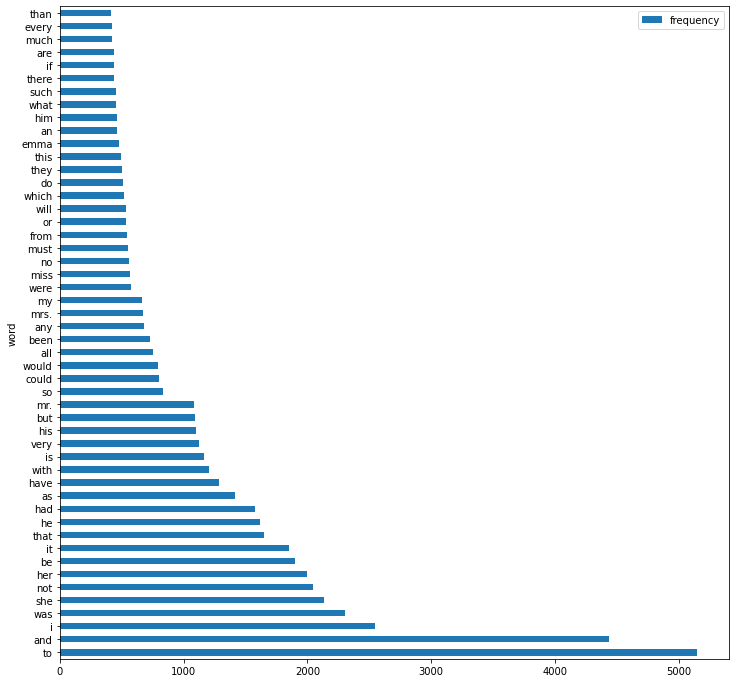

In [51]:


def get_top50(file):
  lines = sc.textFile(file)
  flat_lines = lines.flatMap(lambda x: x.split(' '))
  tuples = flat_lines.map(lambda x: (x.lower(), 1))
  word_count = tuples.reduceByKey(lambda x,y: x+y)
  common = word_count.filter(lambda x: x[1] >= 5)
  stop_words = common.filter(lambda x: x[0] not in stop)
  all = sorted(stop_words.collect(), key=lambda x: x[1], reverse=True)
  top = all[:50]
  return top


emma = get_top50('emma.txt')



import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(emma, columns=['word', 'frequency'])
df.plot.barh(x='word', figsize=[12,12])
